In [12]:
import os
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import json
import pandas as pd 
import numpy as np
import check_parameters
import requests
import matplotlib.pyplot as plt

from csv import reader
import re
from datetime import datetime
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set_theme(style="whitegrid");

# making sure that env variables are set - if they are then nothing will print to screen
g.check_environ_variables()

%matplotlib inline

## Michipicoten, Lake Superior

**Station Name:** 	mchn

**Location:** Michipicoten Harbour, Ontario, Canada

**Archive:**  [SOPAC](http://sopac-csrc.ucsd.edu/index.php/sopac/), [NRCAN](https://www.nrcan.gc.ca/home)

**Ellipsoidal Coordinates:**

- Latitude: 47.961

- Longitude: -84.901

- Height: 152.019 m

[Station Page at Natural Resources Canada](https://webapp.geod.nrcan.gc.ca/geod/data-donnees/station/report-rapport.php?id=M093001)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/MCHN.sta)

[Google Maps Link](https://goo.gl/maps/mU5GbsvMsLfe5buQ7)

<img src="mchn_monu-cors.png" width="500"/>

## Data Summary

Station mchn is operated by NRCAN. The station overlooks Lake Superior from the Canadian shore, in a favorable location for measuring seasonal water levels.

This site only tracks GPS. Unfortunately only L1 data should be used at this site. The L2 data at mchn do not meet basic quality standards, and the L5 signal is not tracked.

More information on the station can be obtained from the GNSS-IR Web App, where mchn is one of the [test cases](https://gnss-reflections.org/api?example=mchn) for water level.
The web app returns a photograph, coordinates (make a note of them),
a Google Earth map, and a periodogram which we will reproduce in this tutorial.

In [9]:
%%html
<iframe src="https://gnss-reflections.org/api?example=mchn" width="800" height="950"></iframe>

### Setting Azimuth and Elevation Mask

From the periodogram and Google Earth a good 
azimuth mask can be selected.  Elevation angle might be a bit trickier, but in this case, go ahead and 
use the default values included in the title of the periodogram plot from the web app. The web app has an option to calculate the reflection zones ("ReflZones" link located in the bar at the top of the page). [Below is a good start on an elevation and azimuth angle mask](https://gnss-reflections.org/rzones?station=mchn&msl=on&RH=7&eang=2&azim1=80&azim2=180). The reflection zones at 5, 10, and 15-degree elevation angles are plotted as colored ellipses surrounding the station, all overlaid on a Google Earth map.  Higher elevation angles are closer to the station.  From the map, it is possible to pick out the azimuth range and reflection zones that are over water instead of than land.

In [10]:
%%html
<iframe src="https://gnss-reflections.org/rzones?station=mchn&msl=on&RH=7&eang=2&azim1=80&azim2=180" width="950" height="700"></iframe>

## Reproduce the Web App 

### Make SNR File

If you know where the data are stored (i.e. sopac), it is better (faster) to set that flag.
Since the receiver only tracks GPS signals, there is no need to specify gnss orbits.

In [3]:
station = 'sbas'
year = 2018 
doy = 1

In [14]:
# To understand what rinex2snr returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
check_parameters.rinex2snr?

In [5]:

args = check_parameters.rinex2snr(station, year, doy, archive='special', translator='hybrid', orb='igs')
rnx.run_rinex2snr(**args)

Will seek RINEX file  sbas  year: 2018  doy: 1  translate with  hybrid
using IGS final orbits, so only GPS
igs19821.sp3 /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2018/sp3
Either the RINEX file or orbit file does not exist, so there is nothing to convert


### Quick Look at Data

Use **quickLook** to examine the spectral characteristics of the SNR data for the default L1 settings:

In [5]:
# making a plotting function for the quicklook function
def quicklook_results(args, values):
    freq = {1:'L1', 20: 'L2C'}
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    quadrants = ['NW', 'NE', 'SW', 'SE']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    for i, quadrant in enumerate(quadrants):
        satellites = values[quadrant].keys()
        fail_satellites = values[f'f{quadrant}'].keys()

        for failsat in fail_satellites:
            axes[i].plot(values[f'f{quadrant}'][failsat][0], values[f'f{quadrant}'][failsat][1], color='lightgrey') 
        for sat in satellites:
            axes[i].plot(values[quadrant][sat][0], values[quadrant][sat][1])

    ax[0,0].set_title('Northwest', size=14)
    ax[0,1].set_title('Northeast',size=14)
    ax[1,0].set_title('Southwest', size=14)
    ax[1,1].set_title('Southeast', size=14)

    for ax in axes:
        ax.set_xlabel('reflector height (m)', size=14)
        ax.set_ylabel('volts/volts', size=14)
        ax.grid()
    
    fig.suptitle(f'GNSS Station {args["station"].upper()}, {args["year"]} doy {args["doy"]}, freq {freq[args["f"]]}, elevation angles {args["e1"]}-{args["e2"]} \n', size=16)
    fig.tight_layout()
    plt.show()
    
    
def quicklook_metrics(args, values):
#     fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
    quadrants = ['NW', 'NE', 'SW', 'SE']
    
    # re-organizing the data in a plotting friendly format
    success_data = {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise':[], 'Amplitude': []}
    fail_data =  {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise': [], 'Amplitude': []}
    
    for i, quadrant in enumerate(quadrants):
        for j in values[quadrant].keys():
            success_data['Azimuth'].append(datakeys[quadrant][j][0])
            success_data['Reflector Height'].append(datakeys[quadrant][j][1])
            success_data['Peak to Noise'].append(datakeys[quadrant][j][5])
            success_data['Amplitude'].append(datakeys[quadrant][j][4])
        for k in values[f'f{quadrant}'].keys():
            fail_data['Azimuth'].append(datakeys[f'f{quadrant}'][k][0])
            fail_data['Reflector Height'].append(datakeys[f'f{quadrant}'][k][1])
            fail_data['Peak to Noise'].append(datakeys[f'f{quadrant}'][k][5])
            fail_data['Amplitude'].append(datakeys[f'f{quadrant}'][k][4])

    return pd.DataFrame(success_data), pd.DataFrame(fail_data)   

In [ ]:
# To understand what quicklook returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
# check_parameters.quicklook?

minimum elevation angle (degrees) for this dataset:  0.1613


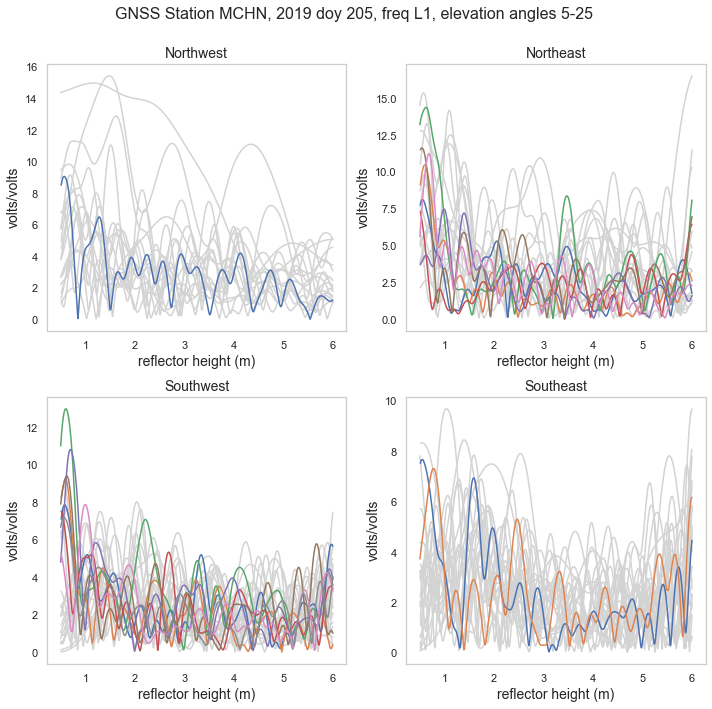

In [6]:
args = check_parameters.quicklook(station, year, doy=doy)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

Why does this not look like the results from the web app? Look closely at the station photo and the x-axis of the periodograme, then change the range of reflector heights at the command line for **quickLook**:

minimum elevation angle (degrees) for this dataset:  0.1613


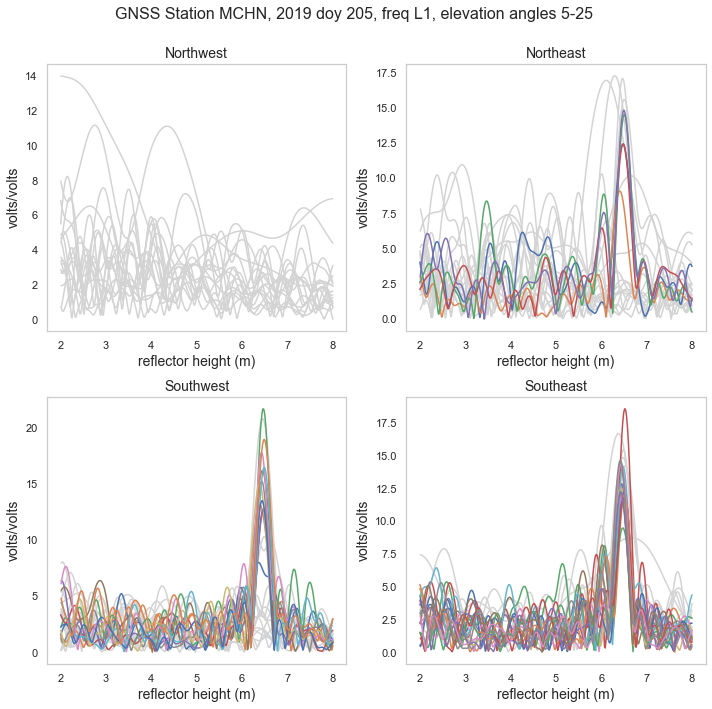

In [8]:
# Changing the range of reflector heights frome the default to 2-8
args = check_parameters.quicklook(station, year, doy=doy, h1=2, h2=8)
values, datakeys = quick.quickLook_function(**args)

quicklook_results(args, values)

Also look at the QC metrics:

Average reflector height value: 6.5
QC value for peak to noise: 3
QC value for amplitude: 8


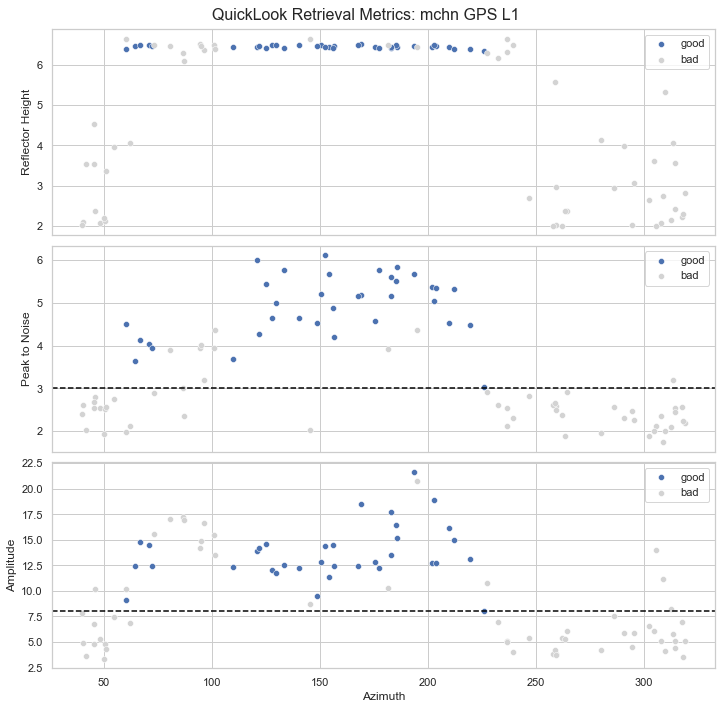

In [10]:
success, fail = quicklook_metrics(args, datakeys)
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook Retrieval Metrics: {args["station"]} GPS L1', size=16)

for i, ax in enumerate(axes):
    g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
    g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')
    
axes[0].legend(loc='upper right')
avg_rh = np.mean(success['Reflector Height'])
qc_val_peak2noise = round(min(success['Peak to Noise']))
axes[1].axhline(qc_val_peak2noise, linestyle='--', color='black', label='QC value used')
qc_val_amp = round(min(success['Amplitude']))
axes[2].axhline(qc_val_amp, linestyle='--', color='black', label='QC value used')
print(f'Average reflector height value: {avg_rh:.1f}')
print('QC value for peak to noise:', qc_val_peak2noise)
print('QC value for amplitude:', qc_val_amp)

plt.tight_layout()
plt.show()

The water is ~6.5 meters below the antenna. You can see from the top plot that the good retrievals (blue dots) very clearly show you which azimuths are acceptable and which are not. The middle plot shows the peak to noise ratio, which we would like to at least exceed 3. Here, the bad retrievals are always below this level. The amplitudes in the bottom plot indicate that 8 is an acceptable minimal value.

## Analyze the Data

The data from 2013 will be analyzed for this use case.  Begin by generating the SNR files:

In [11]:
station = 'mchn'
year = 2013 
doy = 1

lat = 47.961
long = -84.901
height = 152.019

args = check_parameters.rinex2snr(station,year,doy, doy_end=365, archive='sopac', translator='hybrid')
rnx.run_rinex2snr(**args)

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0010.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0020.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0030.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0040.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0050.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0060.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0070.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0080.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0090.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0100.13.snr66
SNR file exists /Use

Either the RINEX file or orbit file does not exist, so there is nothing to convert
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0940.13.snr66
Will seek RINEX file  mchn  year: 2013  doy: 95  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0960.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0970.13.snr66
Will seek RINEX file  mchn  year: 2013  doy: 98  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 99  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 100  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Wi

Either the RINEX file or orbit file does not exist, so there is nothing to convert
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1970.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1980.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1990.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2000.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2010.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2020.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2030.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2040.13.snr66
SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2050.13.snr66
SNR file exists /Users/enloe/UNAVCO

Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 281  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 282  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 283  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 284  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 285  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is nothing to convert
Will seek RINEX file  mchn  year: 2013  doy: 286  translate with  hybrid
Either the RINEX file or orbit file does not exist, so there is 

The resulting files are stored in $REFL_CODE/2013/snr/mchn. REFL_CODE is set to this current directory.

Analysis parameters are set up with **make_json_input**.

In [11]:
# To understand what make_json returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
#check_parameters.make_json?

In [13]:
check_parameters.make_json(station, lat, long, height, h1=3, h2=10, peak2noise=3, ampl=8, l1=True)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/mchn.json


While most of the analysis settings can be set in the make_json function, we must set the azimuths by 'hand' to be limited to 80-180 degrees. Although it is possible to get good reflections beyond 180 degrees, the photographs suggest barriers are present in that region.

In [15]:
# This is the json file that was created
json_file = 'input/mchn.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    file['azval'] = [80, 180]

os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'mchn',
 'lat': 47.961,
 'lon': -84.901,
 'ht': 152.019,
 'minH': 3,
 'maxH': 10,
 'e1': 5,
 'e2': 25,
 'NReg': [3, 10],
 'PkNoise': 3,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [80, 180],
 'freqs': [1],
 'reqAmp': [8],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'mchn_lsp.png',
 'delTmax': 75}

Now that the analysis parameters are set, run **gnssir** to save the reflector height (RH) output for each day in 2013.

In [ ]:
# To understand what gnssir returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
# check_parameters.gnssir?

In [16]:
doy = 1
doy_end=365
args = check_parameters.gnssir(station, year, doy=1, doy_end=365, plt=False, screenstats=False)

year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//032.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0320.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//033.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0330.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//034.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0340.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//035.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0350.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//036.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//071.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0710.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//072.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0720.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//073.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0730.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//074.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn0740.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//075.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//110.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1100.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//111.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1110.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//112.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1120.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//113.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1130.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//114.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//149.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1490.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//150.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1500.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//151.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1510.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//152.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1520.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//153.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//188.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1880.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//189.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1890.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//190.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1900.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//191.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1910.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//192.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//227.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2270.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//228.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2280.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//229.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2290.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//230.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2300.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//231.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//266.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2660.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//267.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2670.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//268.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2680.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//269.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn2690.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//270.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//305.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3050.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//306.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3060.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//307.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3070.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//308.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3080.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//309.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//344.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3440.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//345.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3450.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//346.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3460.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//347.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn3470.13.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//348.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

The daily output files are stored in $REFL_CODE/2013/results/mchn. There is an option to plot periodograms, but for a year's worth of data this is not recommended.  Instead it is better to look at the periodograms for a single day.  Separate periodograms will be generated for all frequency codes listed in the json file, but only those frequency for which SNR data are available will have spectra plotted, i.e., no data will produce a blank plot.  The messages printed to the screen can also be reduced with the screenstats flag (this option can be manually set in the json file too):

[195]
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/results/mchn//195.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2013/snr/mchn/mchn1950.13.snr66


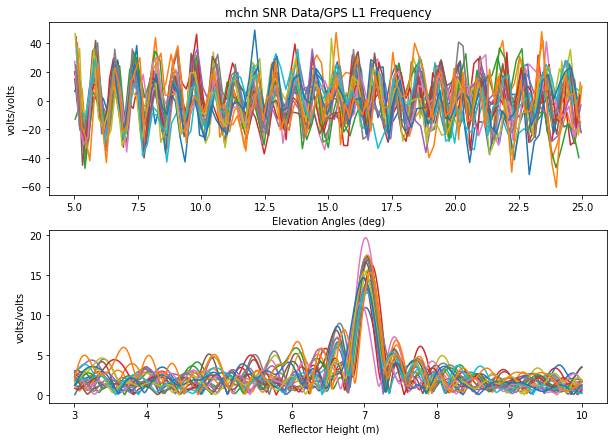

In [15]:
doy = 195
args = check_parameters.gnssir(station, year, doy=doy, plt=True, screenstats=False)

year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
print(doy_list)
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

There are still outliers in the solutions - and in principle these can be reduced by experimenting with better restrictions, i.e. increase the amplitude requirement or peak to noise restriction. If the outliers are not taken into account, they will show up in the daily average:

Let's set the median filter to allow any value within 2 meters of the median. The number of tracks needed to compute an average will be 10.

In [228]:
# To understand what daily_avg returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
# check_parameters.daily_avg?

In [27]:
check_parameters.daily_avg(station, medfilter=2, ReqTracks=10, plt2screen=False, txtfile='mchn-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/mchn_allRH.txt
Number of files in  2013 332
not enough retrievals on  2013 11 13 10
not enough retrievals on  2013 11 11 9
not enough retrievals on  2013 11 25 1
not enough retrievals on  2013 12 5 10
not enough retrievals on  2013 10 26 8
not enough retrievals on  2013 1 16 1
not enough retrievals on  2013 7 19 7
not enough retrievals on  2013 1 4 3
not enough retrievals on  2013 1 10 10
not enough retrievals on  2013 1 12 4
not enough retrievals on  2013 1 13 8
not enough retrievals on  2013 1 7 9
not enough retrievals on  2013 12 6 2
not enough retrievals on  2013 8 25 6
not enough retrievals on  2013 1 9 7
not enough retrievals on  2013 1 8 8
not enough retrievals on  2013 12 10 10
not enough retrievals on  2013 11 30 5
not enough retrievals on  2013 11 5 6
not enough retrievals on  2013 4 4 10
not enough retrievals on  2013 11 20 10
not enough retrievals on  2013 11 14 1
Daily average RH png file s

In [28]:
def read_allRH_file(filepath, regex):
    data = {'dates': [], 'rh': []}
    #read daily average reflector heights
    with open(f'{refl_code_dir}{filepath}', 'r') as myfile:
        file = myfile.read()
        matches = re.finditer(regex, file, flags=re.MULTILINE)

        for match in matches:
            ydoy = f'{int(match.group("year"))}-{int(match.group("doy"))}'
            date = datetime.strptime(ydoy, '%Y-%j').date()
            data['dates'].append(date)
            data['rh'].append(float(match.group('rh')))
            
    return data

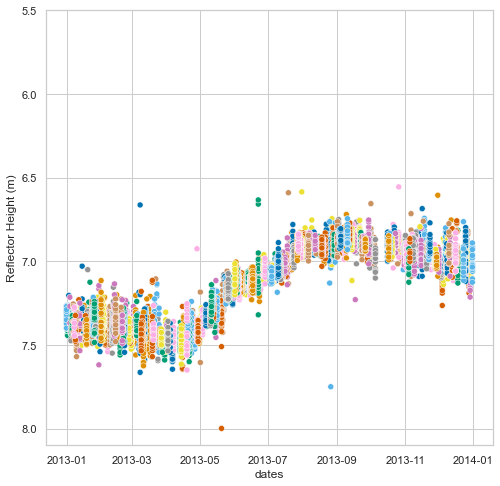

In [29]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}_allRH.txt'
data = read_allRH_file(filepath, regex)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim(8.1,5.5)
g.set_ylabel('Reflector Height (m)');

A more reasonable result is obtained with a 0.25-meter median filter and the 12-track requirement. The output daily averages are saved with the txtfile parameter.

In [30]:
check_parameters.daily_avg(station, medfilter=.25, ReqTracks=12, plt2screen=False, txtfile='mchn-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/mchn_allRH.txt
Number of files in  2013 332
not enough retrievals on  2013 11 13 10
not enough retrievals on  2013 9 18 12
not enough retrievals on  2013 11 11 9
not enough retrievals on  2013 11 25 1
not enough retrievals on  2013 4 22 12
not enough retrievals on  2013 12 5 10
not enough retrievals on  2013 10 26 7
not enough retrievals on  2013 1 16 1
not enough retrievals on  2013 7 19 6
not enough retrievals on  2013 12 28 12
not enough retrievals on  2013 1 4 3
not enough retrievals on  2013 1 10 10
not enough retrievals on  2013 1 12 4
not enough retrievals on  2013 1 13 8
not enough retrievals on  2013 1 7 9
not enough retrievals on  2013 12 6 2
not enough retrievals on  2013 8 25 6
not enough retrievals on  2013 1 9 7
not enough retrievals on  2013 12 8 11
not enough retrievals on  2013 1 8 8
not enough retrievals on  2013 12 10 10
not enough retrievals on  2013 11 30 4
not enough retrievals on 

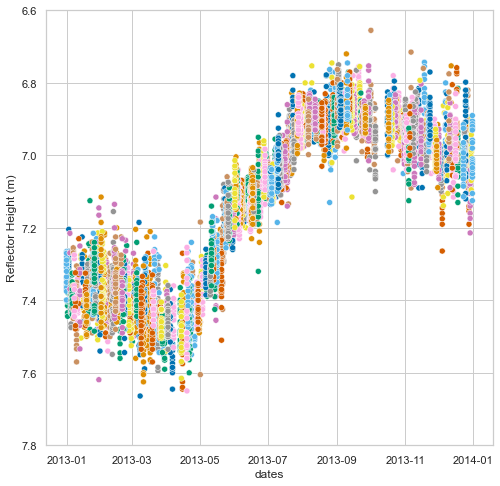

In [36]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}_allRH.txt'
data = read_allRH_file(filepath, regex)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim(7.8,6.6)
g.set_ylabel('Reflector Height (m)');

and for the average

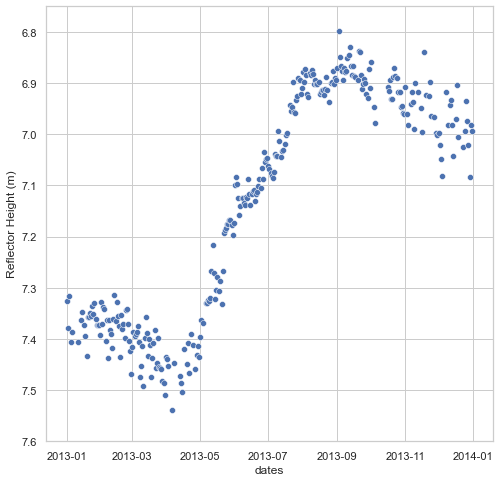

In [37]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}-dailyavg.txt'
data = read_allRH_file(filepath, regex)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(7.6,6.75)
g.set_ylabel('Reflector Height (m)');

The number of tracks required will depend on the site. Here the azimuth is restricted because mchn is on the coastline of Lake Superior, so the azimuth mask will limit the number of satellite tracks available.
Please note that these reflections are from ice in the winter and water during the summer.

Note: there is a [tide gauge](https://tides.gc.ca/eng/Station/Month?sid=10750) at this site. The tide gauge is operated by the Canadian Hydrographic Service within Fisheries and Ocean Canada.  The tide data can be downloaded from [this link](http://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/interval-intervalle-eng.asp?user=isdm-gdsi&region=CA&tst=1&no=10750).  Please select the daily mean water level, as there are restrictions on hourly data (more information is available on the download page).  A csv file is generated after a request is submitted.

The daily mean water level during 2013 looks like:


In [ ]:
def read_tide_file(file, regex):
    #set up empty lists
    data = {'tidedates': [], 'waterlevel': []}

    #read tide data 
    with open(f'{refl_code_dir}{file}', 'r') as myfile:
        data = myfile.read()
        matches = re.finditer(regex, data, flags=re.MULTILINE)


        for match in matches:
            data['tidedates'].append(datetime.strptime(match.group('date'), '%Y-%m-%d'))
            data['waterlevel'].append(float(match.group('slev')))

    return data

#both tidegauge and gps data sets have gaps, so pad the missing days with nan (also generate a date vector for the full year)

def addnans(ymdvec, datavec):
    yearvec=[]
    paddedvec=[]
    date1 = datetime.fromisoformat('2013-01-01')
    date2 = datetime.fromisoformat('2013-12-31')
    ct_day = date1
    
    for day in range(0, 365):
        yearvec.append(ct_day)
        ct_day = ct_day + timedelta(days=1)
        
    tmp = math.nan
    for i in range(0, len(yearvec)):
        for j in range(0, len(ymdvec)):
            if yearvec[i] == ymdvec[j]:
                tmp = datavec[j]
        paddedvec.append(tmp)
        tmp = math.nan

    return yearvec, paddedvec

            
def getrms(residuals):
    val = np.sqrt((residuals**2).mean())
    return val

In [ ]:
## NEED TO FIX ALL THIS


regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}-dailyavg.txt'
data = read_allRH_file(filepath, regex)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
# plt.figure(figsize=(8,8))
# g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
# g.set_ylim(7.6,6.75)
# g.set_ylabel('Reflector Height (m)')

tide_file_path = '10750-01-JAN-2013_slev.csv'
regex = '(?P<date>^[\d|-]+),(?P<slev>[-|\d|.]*),'
    
data = read_tide_files(tide_file_path, regex)
df = pd.DataFrame(data, index=None, columns=['Dates', 'Water Level'])

#pad missing days with nan
ymd, padded_rh = addnans(mchndates, reflht)
ymd, padded_wl = addnans(tidedates, waterlevel)

    #create numpy array objects
    rh_array = np.array(padded_rh)
    wl_array =np.array(padded_wl)

    #get linear regression (use scipy but mask out nans)
    mask = ~np.isnan(rh_array) & ~np.isnan(wl_array)
    
    slope, intercept, r_val, p_val, std_err = stats.linregress(rh_array[mask], wl_array[mask])
    checkfit = slope*rh_array[mask] + intercept
    
    resids = [i - j for i, j in zip(wl_array[mask], checkfit)]
    resids_array = np.array(resids)
    rms_resids = getrms(resids_array)
    slope = float("{0:.2f}".format(slope))
    intercept = float("{0:.2f}".format(intercept))
    r_val = float("{0:.3f}".format(r_val))
    p_val = float("{0:.2f}".format(p_val))
    std_err = float("{0:.3f}".format(std_err))
    rms_resids = float("{0:.3f}".format(rms_resids))

    #plot reflector height vs. water level (using masked values)

    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(rh_array[mask], checkfit, '-', color='black')
    ax.scatter(rh_array[mask], wl_array[mask], color = 'tab:blue')
    
    ax.set_xlabel("Reflector Height (m)", fontsize=16)
    ax.set_ylabel("Water Level (m)", fontsize=16)
    ax.set_title('MCHN Reflector Height vs. Tide Gauge Measurements', fontsize=18)
    txtstr = '\n'.join((
        'Slope=%.2f' % (slope, ),
        'Intercept=%.2f' % (intercept, ),
        'Correlation=%.3f' % (r_val, ),
        'P-value=%.2f' % (p_val, ),
        'RMS of Residuals=%.3f' % (rms_resids, )))
    props = dict(boxstyle='round', facecolor='tab:blue', alpha=0.5)
    ax.text(.65, .95, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()

# plot time series for the water levels and reflector heights (with reversed axes)

    fig, ax1 = plt.subplots(figsize=(10, 8))
    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=16)
    ax1.set_ylabel('Tide Gauge Water Level (m)', color='black', fontsize=16)
    ax1.scatter(tidedates, waterlevel, label='Tide Gauge', color=color)
    ax1.tick_params(axis='y', labelcolor='black')
    plt.ylim(-.5,.3)
    plt.grid()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:orange'
    ax2.set_ylabel('GPS Reflector Height (m)', color='black', fontsize=16)  # we already handled the x-label with ax1
    ax2.scatter(mchndates, reflht, label='GPS Reflector Height', color=color)
    ax2.tick_params(axis='y', labelcolor='black')
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax1.xaxis.set_major_formatter(myFmt)
    
    plt.ylim(6.75,7.55)
    plt.gca().invert_yaxis()
    fig.legend(loc='lower right', bbox_to_anchor=(0.93, 0.08), edgecolor='black')
    plt.title('MCHN Tide Gauge Measurements vs. Reflectometry', fontsize=18)
    plt.grid()

    fig.tight_layout()
    plt.show()